# **Supervised Learning**

Supervised learning is where you have input variables $x$ and an output variable $y$ and you use an algorithm to learn the mapping function from the input to the output. $y$=$f(x)$
The variable types can be:
1. Numerical, real number measurements (usually quantitative).
2. Categorical, from a discrete set (often qualitative). E.g. {Spam, Not-spam}.
3. Ordinal, from a discrete set, without metric relation, but allows ranking. E.g. {first, second, third}

We call it 'supervised' because we are providing the model with ground truth output values so that it has a target to aim for.

Supervised learning problems can be further grouped into:

* __Regression__: A regression problem is when the output variable is a real value, such as “dollars” or “weight”. For an example of a regression model,
see https://online.stat.psu.edu/stat501/lesson/5/5.3
* __Classification__: A classification problem is when the output variable is a category, such as “red” or “blue” or “disease” and “no disease”.





## Classification Example



### The Data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model as LM
from sklearn import neighbors as NB
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import decomposition
# below libraries are necessary for downloading data.
import os
import shutil

In [ ]:
# Do not edit this code cell as it's necessary to setup the data. We will be rerunning
# the code of top contestants for verification of their solution.
if os.path.exists('/content/data/'):
  shutil.rmtree('/content/data')
# below are bash commands that are run in the computing environment, making a data directory
# and downloading the train and test data. The ! just means run bash code outside of the python
# environment
!mkdir data
!wget https://raw.githubusercontent.com/whitleyo/dcgsa_hackathon/master/data/train.csv -P data
!wget https://raw.githubusercontent.com/whitleyo/dcgsa_hackathon/master/data/test.csv -P data


--2020-11-17 05:26:55--  https://raw.githubusercontent.com/whitleyo/dcgsa_hackathon/master/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18516136 (18M) [text/plain]
Saving to: ‘data/train.csv’

train.csv           100%[===================>]  17.66M  64.1MB/s    in 0.3s    

2020-11-17 05:26:55 (64.1 MB/s) - ‘data/train.csv’ saved [18516136/18516136]

--2020-11-17 05:26:55--  https://raw.githubusercontent.com/whitleyo/dcgsa_hackathon/master/data/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4646276 (4.4M) [text/pl

In [ ]:
# Load in Data
top_dir = '/content'
data_dir = os.path.join(top_dir, 'data')
train_file = os.path.join(data_dir, 'train.csv')
test_file = os.path.join(data_dir, 'test.csv')
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

The first column is gene name, second denotes if a gene is a core essential gene, third through 8th (A375-RPE1) denote expression in cell lines, and everything after that denotes if the gene has a physical interaction with the gene denoted in the column. The gene expression data and essentiality labels were pulled from [Hart et al. 2015](https://www.cell.com/fulltext/S0092-8674(15)01495-6) while the PPI data was pulled from the [Intact Database](https://www.ebi.ac.uk/intact/)

In [ ]:
train_data 

,gene,IS_CORE_ESSENTIAL,A375,DLD1,GBM,HCT116,HELA,RPE1,MAX,MYCN,NMI,MYC,RPLP1,PDCD4,RPL5,RPS13,EIF4G1,TCF7L2,DAXX,CTNNB1,RUNX3,TLE1,LEF1,YWHAH,GREM1,NDE1,ZNF365,NDEL1,CDK1,UBE2I,TFAP2C,TFAP2A,TFAP2B,EP300,CITED2,ETS2,TWIST1,TWIST2,TP53,MDM2,...,TYMP,TSEN15,RAP1A,PSMB6,RAP1B,FOXA1,GFI1,NPY1R,PYY,CALCA,CALCRL,NPY2R,CXCR2,IL4R,IL4,EDNRA,EDN1,EDNRB,CCR3,CCL11,SIAH2,CASP10,CFLAR,BECN1,IRS1,BARD1,TDRD7,CDK17,LSM7,BNIP3L,BNIP2,BNIP3,SUV39H1,TGFB2,TPD52,TPD52L1,VANGL1,CD82,MAST2,CDHR2
0,SLC7A4,0,-5.887,-5.845,-6.644,-6.644,-6.644,-5.265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ERCC4,1,2.344,2.051,2.604,2.239,2.795,2.246,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,EIF3G,1,7.561,7.053,6.966,7.232,6.758,6.816,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,LARP1B,0,3.050,3.706,2.725,3.750,2.309,3.159,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,DHX29,0,4.503,4.032,3.726,3.898,3.181,4.073,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2706,WDR13,0,5.391,6.390,5.277,5.297,5.640,5.233,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2707,RPL29,1,9.948,10.408,9.862,10.019,9.013,9.449,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2708,TRMU,0,4.153,5.689,4.532,5.266,5.306,5.272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2709,DHX9,1,6.822,6.726,6.558,6.943,6.084,6.365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_data

,gene,IS_CORE_ESSENTIAL,A375,DLD1,GBM,HCT116,HELA,RPE1,MAX,MYCN,NMI,MYC,RPLP1,PDCD4,RPL5,RPS13,EIF4G1,TCF7L2,DAXX,CTNNB1,RUNX3,TLE1,LEF1,YWHAH,GREM1,NDE1,ZNF365,NDEL1,CDK1,UBE2I,TFAP2C,TFAP2A,TFAP2B,EP300,CITED2,ETS2,TWIST1,TWIST2,TP53,MDM2,...,TYMP,TSEN15,RAP1A,PSMB6,RAP1B,FOXA1,GFI1,NPY1R,PYY,CALCA,CALCRL,NPY2R,CXCR2,IL4R,IL4,EDNRA,EDN1,EDNRB,CCR3,CCL11,SIAH2,CASP10,CFLAR,BECN1,IRS1,BARD1,TDRD7,CDK17,LSM7,BNIP3L,BNIP2,BNIP3,SUV39H1,TGFB2,TPD52,TPD52L1,VANGL1,CD82,MAST2,CDHR2
0,PDCD4,0,7.015,6.614,5.821,5.921,7.199,5.618,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,DAXX,0,5.275,5.670,5.319,5.751,4.520,5.507,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,RUNX3,0,3.581,-4.866,-4.808,3.612,0.051,-5.703,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,TLE1,0,4.237,4.221,5.037,2.818,1.998,4.018,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,GREM1,0,-5.200,-5.520,-6.322,-6.179,-3.027,7.558,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,TGFB2,0,-1.994,5.016,-0.448,-1.983,-0.146,6.664,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
674,TPD52,0,5.640,6.747,-5.381,6.984,6.346,1.369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
675,TPD52L1,0,4.521,5.792,4.425,4.604,5.937,4.751,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
676,CD82,0,2.441,1.324,2.578,3.576,5.532,4.880,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Logistic Regression

Let $y$ be 1 if the gene is essential and 0 otherwise, and let $x_1$, ..., $x_n$ be various features in the data respectively. 

Our attempt at prediction will use what's known as a __logistic regression model__, where we make an estimate 
$$\hat{y} = 1/(1 + e^{-(\theta_0 + \theta_1x_1 + \theta_nx_n)})$$

Where $\theta_0$ is an intercept and $\theta_ix_i$ are all weights determining how strong each of the features weigh in. In this case, we have n = 5 features for training.



$\hat{y}$ can be thought of as a predicted class probability.

If $\hat{y}$ is a good estimate, $\hat{y}$ - $y$ should be small.

We can give ourselves a score (__loss function__) $$CE = Cross Entropy = -{(y\log(\hat{y}) + (1 - y)\log(1 - \hat{y}))}$$ to tell us how well (or badly) we're doing. 

If Cross Entropy sounds scary, don't worry, for our purposes it's just a score.

Suppose for a given sample, we have
y = 1. Then this would be the relationship between our score (log loss) and our prediction:

![](https://ml-cheatsheet.readthedocs.io/en/latest/_images/cross_entropy.png)

Image was ripped off from https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html

Notice that there's a pretty stiff penalty for giving a very wrong prediction, but the penalty quickly diminishes. It is left as an exercise for the reader to
draw what the log loss would look like if the true label was 0.

### Training, (Cross) Validation, and Testing

A supervised learning model will usually have the following components:
* a set of parameters used in a function to make predictions (non-parametric models such as K-Nearest Neighbors are an exception)
* one or more hyperparameters usually controlling how strongly the model is allowed to fit to data provided

As an example, for logistic regression model, we would have a __loss function__ like this:

 $$1/m * \sum_{i=1}^m CE_i + \alpha*\sum_{k=1}^n\theta_k^2$$

The left term with is the cross entropy score calculated for datapoint i's prediction $\hat{y_i}$ and it's real value $y_i$, and tells you how badly your model is doing
on average in the data we provided (we want to minimize this).

The right hand with the $\theta$ s provides a penalty on having the parameters deviate too far from zero. The hyperparameter $\alpha$ is a constant determining how strong the penalty (called __regularization__) is.

Why would you provide a penalty that has nothing to do with how well you're doing on the data provided? Let's split the dataset in 2:


In [ ]:
# columns 2 (0 is first column) to 7 gives gene expression. For today, we will only be using gene expression information
# for prediction
# column 1 gives us our label
X_train = train_data.iloc[:, 2:7].to_numpy().astype('float32')
y_train = train_data.iloc[:, 1].to_numpy().astype('float32')

X_test = test_data.iloc[:, 2:7].to_numpy().astype('float32')
y_test = test_data.iloc[:, 1].to_numpy().astype('float32')

In [ ]:
X_train.shape

(2711, 5)

In [ ]:
y_train.shape

(2711,)

In [ ]:
y_test.shape

(678,)

And now let's fit a logistic regression model with varying strengths of regularization. The term C for sklearn's API is an inverse of regularization strength, or $\alpha$. Let's score the train data (which we use to train the model) and the test data (unseen by the model) with various regularization strengths.

In [ ]:
train_score = []
test_score = []
Cs = np.exp(np.arange(-30, 30, 5))
for C in Cs:
  LR_model = LM.LogisticRegression(penalty='l2', C = C, max_iter = 1000)
  LR_model.fit(X_train, y_train)
  train_score.append(LR_model.score(X_train, y_train))
  test_score.append(LR_model.score(X_test, y_test))



In [ ]:
log_Cs = np.log(Cs)
df_dict = {'train': train_score, 'test': test_score, 'log_C': log_Cs}
df = pd.DataFrame.from_dict(df_dict)
df

,train,test,log_C
0,0.659535,0.669617,-30.0
1,0.789008,0.789086,-25.0
2,0.789008,0.789086,-20.0
3,0.789008,0.789086,-15.0
4,0.789008,0.789086,-10.0
5,0.777573,0.775811,-5.0
6,0.776097,0.774336,0.0
7,0.776097,0.774336,5.0
8,0.776097,0.774336,10.0
9,0.776097,0.774336,15.0


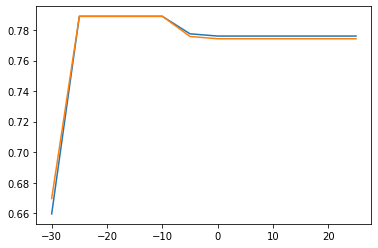

In [ ]:
# Train score is in blue. Test score is in orange
# X axis is log C (log inverse regularization strength)
# Y axis is accuracy

sns.lineplot(x = log_Cs, y = train_score)
sns.lineplot(x = log_Cs, y = test_score)

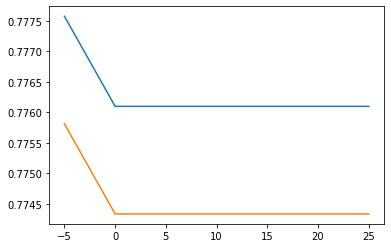

In [ ]:
sns.lineplot(x = log_Cs[-7:], y = train_score[-7:])
sns.lineplot(x = log_Cs[-7:], y = test_score[-7:])

In [ ]:
np.max(test_score)

0.7890855457227138

Note that there appears to be an optimal regularization stength between about -25 and -10, after which the test score is below the train score. Generally, it's expected that after a certain point, very weak regularization will result in the model performing better on training data than on test data.

What we have is still actually pretty good, but we can do better. In real life datasets, the fall in accuracy on test data will often be even greater. So how do we train a model that does well on train AND test?

#### Setup Options

In supervised learning, there are two basic setups for training and evaluating your model. Today we will only run code for option 2.

##### Option I: Train, Validation, Retrain, Test
  * split data into training data (50%), validation data (20%) and test data (30%), or with percentages along those lines
  * For each option of hyperparameter(s)
      1. Train on training data
      2. Compute loss on validation data
  * Select hyperparameter(s) giving lowest value for loss function (validation loss)
  * Retrain model on combination of training + validation data
  * Assess retrained model on test data

![](https://miro.medium.com/max/700/1*Nv2NNALuokZEcV6hYEHdGA.png)

##### Option 2 (Cross Validation):
  * split data into training data (70%) and test data (30%)
  * split training data into K groups (K-
  * For each option of hyperparameter(s)
    1. Train on K - 1 of the K groups (e.g. 80% of the data), and compute loss on the remaining (e.g. 20%) data
    2. Repeat this process until you've rotated through every group for computing loss. Calculate the average loss for your runs.
  * Select hyperparameter(s) with lowest average loss, and retrain model on full dataset
  * Assess retrained model on test dataset
  * An advantage of cross validation is that you're taking an average over random train/validation splits as opposed to basing your choice of hyperparameter on the result of one train/validation split. The disadvantage is that you multiply the number of computations by K, which can become impractical for very large datasets (e.g. 10s of 1000s or millions of examples).

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

Image ripped off from sklearn cross validation webpage.

We would expect the cross validation accuracy vs train accuracy to look something like this (pulled from [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html)):

![](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-validation-curve.png)

Where model complexity is inversely associated with regularization strength. There will be some optimal point where you do as well as possible on your test data.

OK! Let's train a model!





In [ ]:
# object gives API for doing cross validation and retraining model
# l2 just means we're using the parameter penalty outlined earlier today
logistic = LM.LogisticRegression(penalty = 'l2', max_iter = 100)
# we provide a dictionary with a wider set of Cs as our range of hyperparameter
logistic_param_grid = {'C': Cs}
# we do 10 fold cross validation to get a robust-ish average. use accuracy score
logistic_CV_search = GridSearchCV(logistic, logistic_param_grid, scoring = 'accuracy', cv = 10)
logistic_CV_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([9.35762297e-14, 1.38879439e-11, 2.06115362e-09, 3.05902321e-07,
       4.53999298e-05, 6.73794700e-03, 1.00000000e+00, 1.48413159e+02,
       2.20264658e+04, 3.26901737e+06, 4.85165195e+08, 7.20048993e+10])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accurac

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


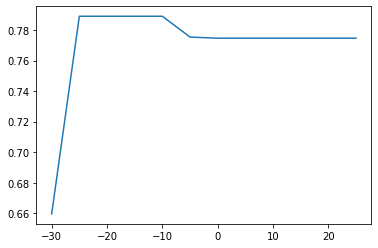

In [ ]:
sns.lineplot(log_Cs, logistic_CV_search.cv_results_['mean_test_score'])

We see that optimal regularization strength is roughly where we had it before.

In [ ]:
# mean CV accuracy with best hyperparameter alpha
np.max(logistic_CV_search.cv_results_['mean_test_score'])

0.7890085739092685

In [ ]:
logistic_CV_search.score(X_test, y_test)

0.7890855457227138

OK, so going through all this hyperparameter optimization didn't substantially improve our model relative to what we got out of choosing the best hyperparams in train vs test before, but in real life you NEVER want to optimize hyperparameters by checking against the test set. The test set is there specifically so that you see how well your model performs on unseen data, and so hyperparameter optimization should only be done on your training data. Thus, going through optimization with cross validation is actually a necessary endeavor.

## __Extra Information (READ THIS)__

You can learn more about Cross Validation and the scikit-learn API [here](https://scikit-learn.org/stable/modules/cross_validation.html)

Here are some more resources you might find useful. Keep in mind you don't have to specifically use logistic regression. There are other methods such as SVMs, random forest, Adaboost, etc. that you can google and try out if you understand.

* [Ensemble Methods](https://scikit-learn.org/stable/modules/ensemble.html#forest)
* [Multilayer Perceptron (Type of Neural Net)](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification)
* [More from sklearn on supervised learning](https://scikit-learn.org/stable/supervised_learning.html)

It should also be noted that there are publicly available notes from U of T for those interested as well as Coursera courses for programming and machine learning. Note that if you want to use ML beyond simple cases, it is strongly recommended you learn basic linear algebra + statistics
* [CSC311 notes]()
* [U of T Coursera Listings](https://onlinelearning.utoronto.ca/coursera/)
* [MIT OCW statistics](https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/)
* [Linear Algebra, University of Waterloo](https://open.math.uwaterloo.ca/)

You're free to use any open source software you'd like, such as sci-kit learn, tensorflow, pytorch, etc, as long as it runs in python in a google colab environment.